In [1]:
assay_index = 21

In [2]:
import pandas as pd
!gsutil cp gs://chem_dsrc/P0_Toxcast/Data/assay_df/*_df.csv ./

Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/335_all_assay_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NCCT_TPO_AUR_dn_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP1A2_df.csv...
Copying gs://chem_dsrc/P0_Toxcast/Data/assay_df/NVS_ADME_hCYP2B6_df.csv...
- [4 files][  4.3 MiB/  4.3 MiB]                                                
Operation completed over 4 objects/4.3 MiB.                                      


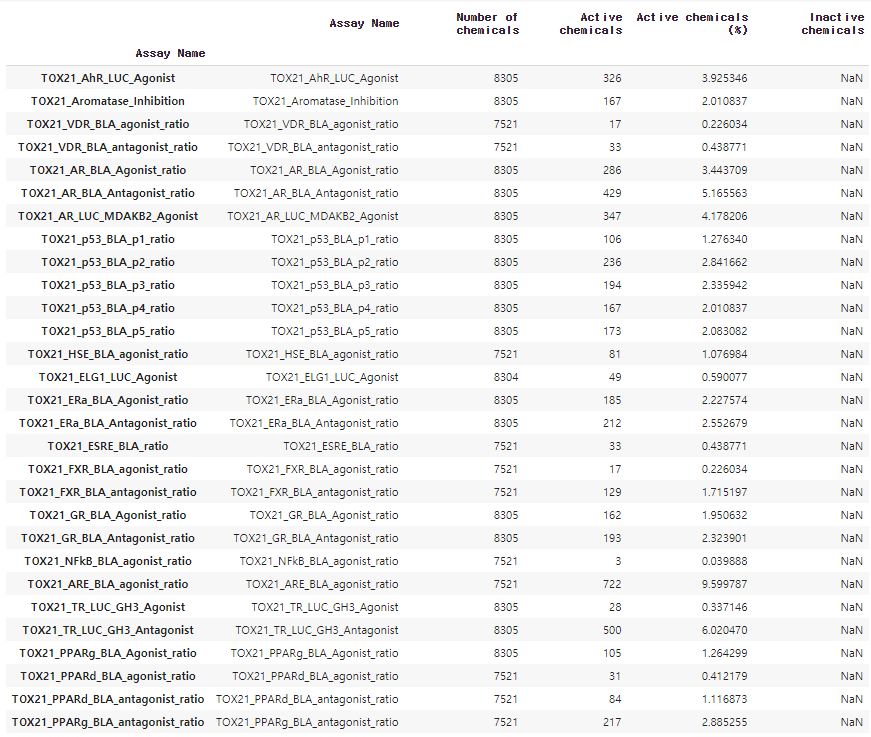

In [3]:
selected_assay_list = ['TOX21_AhR_LUC_Agonist', 'TOX21_Aromatase_Inhibition', 'TOX21_VDR_BLA_agonist_ratio', 'TOX21_VDR_BLA_antagonist_ratio', 'TOX21_AR_BLA_Agonist_ratio', 'TOX21_AR_BLA_Antagonist_ratio', 'TOX21_AR_LUC_MDAKB2_Agonist', 'TOX21_p53_BLA_p1_ratio', 'TOX21_p53_BLA_p2_ratio', 'TOX21_p53_BLA_p3_ratio', 'TOX21_p53_BLA_p4_ratio', 'TOX21_p53_BLA_p5_ratio', 'TOX21_HSE_BLA_agonist_ratio', 'TOX21_ELG1_LUC_Agonist', 'TOX21_ERa_BLA_Agonist_ratio', 'TOX21_ERa_BLA_Antagonist_ratio', 'TOX21_ESRE_BLA_ratio', 'TOX21_FXR_BLA_agonist_ratio', 'TOX21_FXR_BLA_antagonist_ratio', 'TOX21_GR_BLA_Agonist_ratio', 'TOX21_GR_BLA_Antagonist_ratio', 'TOX21_NFkB_BLA_agonist_ratio', 'TOX21_ARE_BLA_agonist_ratio', 'TOX21_TR_LUC_GH3_Agonist', 'TOX21_TR_LUC_GH3_Antagonist', 'TOX21_PPARg_BLA_Agonist_ratio', 'TOX21_PPARd_BLA_agonist_ratio', 'TOX21_PPARd_BLA_antagonist_ratio', 'TOX21_PPARg_BLA_antagonist_ratio']

In [4]:
selected_assay_list.remove('TOX21_NFkB_BLA_agonist_ratio') #active물질 개수가 3개뿐인 assay라 모델 

In [5]:
assay_name = '335_all_assay'
df = pd.read_csv(assay_name+"_df.csv")

In [6]:
df

Unnamed: 0 TOX21_AhR_LUC_Agonist  ... NVS_NR_hPPARg NVS_NR_hPPARa
0         100-00-5                     N  ...             N           NaN
1        1000-05-1                     N  ...           NaN           NaN
2       10001-13-5                     N  ...           NaN           NaN
3         100-01-6                     N  ...           NaN           NaN
4         100-02-7                     N  ...             N           NaN
...            ...                   ...  ...           ...           ...
9219  NOCAS_903892                   NaN  ...           NaN           NaN
9220  NOCAS_903893                   NaN  ...           NaN           NaN
9221  NOCAS_903894                   NaN  ...           NaN           NaN
9222  NOCAS_903895                   NaN  ...           NaN           NaN
9223  NOCAS_903896                   NaN  ...           NaN           NaN

[9224 rows x 337 columns]

In [7]:
ss = selected_assay_list[assay_index] # 그룹
a_i = 0 # assay index
ffpp = "maccs"

In [8]:
# rdkit 2020.03.3 버전 다운로드
!pip install kora -q
import kora.install.rdkit
!pip install pycaret
from pycaret.classification import *
import numpy
import pandas
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys

     |████████████████████████████████| 61kB 3.9MB/s 
     |████████████████████████████████| 61kB 4.3MB/s 
     |████████████████████████████████| 266kB 8.5MB/s 
     |████████████████████████████████| 102kB 6.4MB/s 
     |████████████████████████████████| 215kB 15.2MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 276kB 15.9MB/s 
     |████████████████████████████████| 245kB 20.3MB/s 
     |████████████████████████████████| 2.0MB 33.3MB/s 
     |████████████████████████████████| 1.7MB 42.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 14.2MB 277kB/s 
     |████████████████████████████████| 6.8MB 37.5MB/s 
     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 3.2MB 9.2MB/s 
     |████████████████████████████████| 61kB 5.0MB/s 
    

In [9]:
from pycaret.utils import enable_colab
enable_colab() #to display interactive visuals.

Colab mode enabled.


In [10]:
df_ss = df.loc[:,['smiles',ss]]
df_ss = df_ss.dropna()

In [11]:
assays_ss = df_ss.columns

In [12]:
assays_ss

Index(['smiles', 'TOX21_ARE_BLA_agonist_ratio'], dtype='object')

In [13]:
from imblearn.combine import SMOTEENN 
sme = SMOTEENN(random_state=42,sampling_strategy = "minority")

In [14]:
ss

'TOX21_ARE_BLA_agonist_ratio'

In [15]:
#Smiles --> MACCS Keys
assay = ss
df_train  = df_ss[['smiles',ss] ]

smiles_list = []
err_smiles = []# fingerfrint로 변환시 에러 smiles
fps = []
enc_y = []
for index, row in df_train.iterrows():

  if row[-1] == 'N' : 
    target = 0
  else :
    target = 1

  try : 
    mol = Chem.MolFromSmiles(row['smiles'])
    
    if ffpp == 'maccs' :    
        fp = MACCSkeys.GenMACCSKeys(mol)
    elif ffpp == 'morgan' : 
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    elif ffpp == 'rdkit' : 
        fp = Chem.RDKFingerprint(mol)
    elif ffpp == 'pattern' : 
        fp = Chem.rdmolops.PatternFingerprint(mol)
    elif ffpp == 'layerd' : 
        fp = Chem.rdmolops.LayeredFingerprint(mol)
    else : 
        print("fingerfrint selection error!")
        
    smiles_list.append(row['smiles'])   
    fps.append(fp)
    enc_y.append(target)
  except : 
    err_smiles.append(row['smiles'])
    pass

np_fps = []
for fp in fps:
  arr = numpy.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  np_fps.append(arr)

np_fps_array = numpy.array(np_fps)

print("변환 에러난 smiles 개수 : ", len(err_smiles), err_smiles)

x_train_res, y_train_res = np_fps_array, np.array(enc_y)
train = pd.DataFrame(data=x_train_res)
train['label'] = y_train_res

변환 에러난 smiles 개수 :  7 ['[F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1', 'CC1C=C[C-](=C1)[Mn+]([C-]#[O+])([C-]#[O+])[C-]#[O+]', '[O-]1N2C=CC=CC2=[S][Zn++]11[O-]N2C=CC=CC2=[S]1', '[H][N]([H])([H])[Pt++]([Cl-])([Cl-])[N]([H])([H])[H]', '[Na+].[Na+].F[Si--](F)(F)(F)(F)F', '[H][N]([H])([H])[Pt++]1([O-]C(=O)C2(CCC2)C(=O)[O-]1)[N]([H])([H])[H]', 'C[Sn](C)(|[O]C(=O)CCCCCC(C)(C)C)|[O]C(=O)CCCCCC(C)(C)C']


In [16]:
d = pd.DataFrame(columns = ['smiles','Type'] )
d['smiles'] = smiles_list
d['Type'] = enc_y

In [17]:
d

smiles  Type
0                           [O-][N+](=O)C1=CC=C(Cl)C=C1     0
1             C[SiH](C)O[Si](C)(C)O[Si](C)(C)O[SiH](C)C     0
2                              CN1CCN(CC1)C(=O)C1CCCCC1     0
3                            NC1=CC=C(C=C1)[N+]([O-])=O     0
4                            OC1=CC=C(C=C1)[N+]([O-])=O     0
...                                                 ...   ...
7355    FC1=CC(Br)=C(C=C1)C(=O)NS(=O)(=O)\C=C\C1=CC=CS1     0
7356  OC(=O)C(F)(F)F.CCN(CC)C(=O)C1=C(C=C(N2CCC(CC2)...     0
7357  CC(=O)NC1=NC(=O)N(C=C1)C1COC(COC(=O)C2=CC=CC=C...     0
7358  OC(=O)\C=C\C(O)=O.CCN(CC)CCC1=CNC2=CC=CC=C12.C...     0
7359  CN1CC2=C(N[C@H](CC(O)=O)C1=O)C=CC(=C2)C(=O)N1C...     0

[7360 rows x 2 columns]

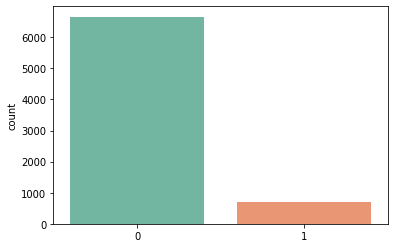

In [18]:
import seaborn as sns
sns.countplot(enc_y, palette="Set2") #팔레트를 이렇게 바꿀수 있구나.

In [19]:
#모든 물질에 대한 fingerprint를 string형태로 바꾼다(비교하기위함).
mychems = []
for item in np_fps:
    #print(item)
    item = np.array(item,dtype=int) #왜 굳이 두번? int형으로 추가하려면 이렇게 하면 되는구나....
    s = item.tolist() #넘파이어레이를 리스트로 바꾼다. 
    t = [str(i) for i in s]
    mychems.append(''.join(t))

In [20]:
i = 0
counter = 0
chemdict = {} #딗셔너리.
listofdups = []
for item in mychems:
    try:
        chemdict[str(item)].append(i)
        #print('dup found')
        for j in range(len(chemdict[str(item)])):
            if (d['Type'][i] != d['Type'][chemdict[str(item)][j]]) :
                listofdups.append(i)
                counter+=1
    except: 
        #print('adding new')
        chemdict[str(item)] = []
        chemdict[str(item)].append(i)
    i+=1
print(str(counter)+' '+str(len(list(set(listofdups)))))
#smote적용하기 전에서 listofdups를 빼면 된다!


269 165


In [21]:
dups_list = list(set(listofdups))

In [22]:
dups_list # 0인것만 지우는게 맞나?

[2562,
 6151,
 2056,
 1048,
 539,
 2592,
 2593,
 5153,
 6691,
 6180,
 3621,
 6184,
 6185,
 2603,
 2604,
 2605,
 5168,
 6709,
 3645,
 580,
 6215,
 3144,
 79,
 6741,
 2650,
 5216,
 6754,
 3684,
 4201,
 2155,
 5740,
 7277,
 6767,
 7279,
 2165,
 2166,
 2167,
 3705,
 3706,
 6782,
 6787,
 5768,
 5769,
 2189,
 6798,
 5273,
 2207,
 4256,
 7359,
 6819,
 2725,
 6821,
 5297,
 3254,
 3769,
 3770,
 1214,
 2238,
 3775,
 4798,
 1218,
 1731,
 1220,
 6335,
 1222,
 1734,
 1224,
 3786,
 1740,
 3277,
 3278,
 1743,
 6348,
 6863,
 6361,
 4827,
 4828,
 4829,
 6878,
 6880,
 4840,
 745,
 749,
 3821,
 3822,
 3823,
 3824,
 5362,
 5363,
 5364,
 2805,
 2806,
 2807,
 5365,
 5368,
 5369,
 764,
 5373,
 4872,
 3850,
 3852,
 4878,
 786,
 2328,
 5401,
 794,
 5403,
 5917,
 1313,
 3876,
 4392,
 3377,
 1842,
 6450,
 2357,
 2873,
 3900,
 5443,
 2373,
 1360,
 6483,
 4442,
 4443,
 5979,
 3935,
 5995,
 2416,
 5488,
 6516,
 373,
 5499,
 1919,
 6528,
 6019,
 2437,
 3465,
 3473,
 3474,
 7062,
 4503,
 3995,
 7075,
 4004,
 5544,
 6

In [23]:
dups_list_0 = []
for index in dups_list : 
  if train.iloc[index].label == 0 :
    dups_list_0.append(index)

In [24]:
train = train.drop(dups_list_0)

In [25]:
train

0    1    2    3    4    5    6    7    8    9   10   11   12   13  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7354  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7355  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7356  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7357  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7358  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7354  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7355  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7356  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7357  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7358  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       28   29   30   31   32   33   34   35   36   37   38   39   40   41  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7354  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
7355  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
7356  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7357  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
7358  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       42   43   44   45   46   47   48   49   50   51   52   53   54   55  \
0     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7354  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0   
7355  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   
7356  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0   
7357  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7358  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

       56   57   58   59   60   61   62   63   64   65   66   67   68   69  \
0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2     0.0  0.0  0.0  0.0  

In [26]:
len(smiles_list)

7360

In [27]:
duplicated_smiles_0_df = pd.DataFrame()
duplicated_smiles_0_df['deleted_duplicate_smiles_0'] = smiles_list
duplicated_smiles_0_df = duplicated_smiles_0_df.iloc[dups_list_0,]
duplicated_smiles_0_df

deleted_duplicate_smiles_0
6151                                 [Cl-].[Cl-].[Ni++]
2056                          CC1(C)N(Br)C(=O)N(Cl)C1=O
2593                           [I-].CCCN1C=C[N+](C)=C1C
5153                        ClC1=CC(Cl)=C(Cl)C(Cl)=C1Cl
6691                                ClC1=CC=CC(Cl)=C1Cl
3621       F[P-](F)(F)(F)(F)F.CCCCCCCCCCN1C=C[N+](C)=C1
2603   F[P-](F)(F)(F)(F)F.CCCCCCCCCCCCCCN1C=C[N+](C)=C1
2604  F[P-](F)(F)(F)(F)F.CCCCCCCCCCCCCCCCN1C=C[N+](C...
6215                  C\C=C(/C)C(=O)OC\C=C(/C)CCC=C(C)C
79                 O.O.O.O.O.O.[Ni++].[O-]S([O-])(=O)=O
6741                  CC(C)(C)C1=CC(O)=C(C=C1O)C(C)(C)C
2650                            NC1=CC=CC2=C(N)C=CC=C12
6754                        [O-][N+](=O)C1=C(Cl)C=CC=C1
3684                                         CC=CC(O)=O
4201         C1=CC2=CC3=CC=C4C=CC=C5C=CC(=C2C=C1)C3=C45
2155                          OC(=O)C1=C(Cl)C=CC(Cl)=N1
5740                            CC(C)=CCCC(C)=CCCC(C)=O
7277                        CC1=CC=C(C=C1C)[N+]([O-])=O
7279                    [O-][N+](=O)C1=CC=C(Cl)C(Cl)=C1
2165                        [Cl-].CCCCCCN1C=C[N+](C)=C1
2166                    [Cl-].CCCCCCCCCCN1C=C[N+](C)=C1
3705  OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F
3706  OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...
6787                  [O-][N+](=O)C1=CC(Cl)=C(Cl)C=C1Cl
5768                                        CCCCCCCCCBr
5769                                      CCCCCCCCCCCBr
6798                      CC1=CC(C)=C(C=C1)[N+]([O-])=O
5273                         [Cl-].CCCCCC[N+]1=CC=CC=C1
2207  OC[C@H]1O[C@@H]2O[C@@H]3[C@@H](CO)O[C@H](O[C@@...
4256     CN(C(=S)OC1=CC2=C(C=C1)C1CCC2C1)C1=CC(C)=CC=C1
7359  CN1CC2=C(N[C@H](CC(O)=O)C1=O)C=CC(=C2)C(=O)N1C...
6819                               CC1=C2C=CC=CC2=CC=C1
2725                      CC(=C)C(=O)OCCOCCOC(=O)C(C)=C
3254                  [Na+].CCCCCCCCCCCCCOS([O-])(=O)=O
1214                                      CCCCCCCC(O)=O
4798            C1=CC2=C(C=C1)C=C1C(C=CC3=C1C=CC=C3)=C2
1218                                         CCCCCCCC=O
1731                                            CCCCCCC
1222                                        CCCCCCCCC=O
1224                                   CCCCCCCCCCCCCC=O
3786  [O-][N+](=O)C1=CC(=CC(=C1Cl)[N+]([O-])=O)C(F)(F)F
1740                                  CCCCCCCCCCCC(O)=O
3277           F[P-](F)(F)(F)(F)F.CCCCCCN1C=C[N+](C)=C1
3278         F[P-](F)(F)(F)(F)F.CCCCCCCCN1C=C[N+](C)=C1
1743                                     CCCCCCCCCCCCBr
6348            CC1=CC(=CC=C1O)C(C)(C)C1=CC(C)=C(O)C=C1
6863                                C1=CC2=CC=CC=C2C=C1
6361            ClC1=CC=C(C=C1)S(=O)(=O)C1=CC=C(Cl)C=C1
4827                  [Br-].CCCCCCCCCCCCCCCC[N+](C)(C)C
4828                              CCCCCCCCCCCCCCCC(O)=O
4829                            CCCCCCCCCCCCCCCCCC(O)=O
6878                               CC1=CC2=CC=CC=C2C=C1
4840                    BrC1=CC2=C(C=CC=C2)C2=C1C=CC=C2
745                                        CCCCCCCCCC=O
5362                                      CCCCCCCCCCCCC
5363                                     CCCCCCCCCCCCCC
5364                                    CCCCCCCCCCCCCCC
5365                                  CCCCCCCCCCCCCCCBr
5368                                   CCCCCCCCCCCCCCCO
5369                                  CCCCCCCCCCCCCCCCC
764                                       CCCCCCCCCCC=O
3850    [O-]S(=O)(=O)C(F)(F)F.CCCCCCCCCCN1C=C[N+](C)=C1
4878  [H][C@@]12CC[C@H](C(C)=O)[C@@]1(C)CC[C@@]1([H]...
2328                  [O-][N+](=O)C1=C(Cl)C=C(Cl)C=C1Cl
5401                          ClC1=C(Cl)C(Cl)=C(Cl)C=C1
794                                  CCCCCCCCCCCCCCCCBr
5403                          ClC1=CC(Cl)=C(Cl)C(Cl)=C1
3876                                            CC=CC=O
3377                      [O-][N+](=O)C1=CC=CC(Cl)=C1Cl
1842                                        ClC\C=C/CCl
2873                   N#CC1=CC2=C(C=CC=C2)C2=C1C=CC=

In [28]:
save_path = 'gs://chem_dsrc/P0_Toxcast/result/29assays_dd/'

In [29]:
dupdf = ss+"_dup_smiles_df.csv"
duplicated_smiles_0_df.to_csv(dupdf)
duppath = save_path + 'err_smiles/'
!gsutil cp $dupdf $duppath

Copying file://TOX21_ARE_BLA_agonist_ratio_dup_smiles_df.csv [Content-Type=text/csv]...
/ [1 files][  4.0 KiB/  4.0 KiB]                                                
Operation completed over 1 objects/4.0 KiB.                                      


In [30]:
import pandas as pd
err_smiles_df = pd.DataFrame(columns = [ss], index = ['err_n','err_smiles'])
err_smiles_df[ss] = [ len(err_smiles), err_smiles]

In [31]:
ersdf = ss+"_err_smiles_df.csv"
err_smiles_df.to_csv(ersdf)
errpath = save_path + 'err_smiles/'
!gsutil cp $ersdf $errpath $errpath

Copying file://TOX21_ARE_BLA_agonist_ratio_err_smiles_df.csv [Content-Type=text/csv]...
Omitting prefix "gs://chem_dsrc/P0_Toxcast/result/29assays_dd/err_smiles/". (Did you mean to do cp -r?)

Operation completed over 1 objects/423.0 B.                                      


In [32]:
err_smiles_df

TOX21_ARE_BLA_agonist_ratio
err_n                                                       7
err_smiles  [[F-][B+3]([F-])([F-])[F-].CC[N+]1(C)CCCC1, CC...

In [33]:
# clf = setup(data = train, target = 'label') 
clf = setup(data = train, target = 'label', fix_imbalance = True, fix_imbalance_method = sme
            ,train_size = 0.9
            ,use_gpu =True
            ,session_id=123) 

Description             Value
0                               session_id               123
1                                   Target             label
2                              Target Type            Binary
3                            Label Encoded        0: 0, 1: 1
4                            Original Data       (7258, 168)
5                           Missing Values             False
6                         Numeric Features                 4
7                     Categorical Features               163
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set       (6532, 163)
12                    Transformed Test Set        (726, 163)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU              True
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              826d
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44                              Clustering             False
45                    Clustering Iteration              None
46                     Polynomial Features             False
47                       Polynomial Degree              None
48                    Trignometry Features             False
49                    Polynomial Threshold              None
50                          Group Features             False
51                       Feature Selection             False
52                Feature Selection Method           classic
53            Features Selection Threshold              None
54                     Feature Interaction             False
55                           Feature Ratio             False
56                   Interaction Threshold              None
57                           Fix Imbalance              True
58                    Fix Imbalance Method          SMOTEENN

# RF - default parameter

In [34]:
save_path_m = save_path+'/rf/'

In [35]:
rf = create_model('rf')
rf_df = pull()
rf_df_name = "rf_df_"+ss+".csv"
rf_df.to_csv(rf_df_name)
rf_df_path = save_path_m+ss+"/"
!gsutil cp $rf_df_name $rf_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8502  0.6954  0.3750  0.2927  0.3288  0.2459  0.2483
1       0.8150  0.6669  0.2656  0.1868  0.2194  0.1180  0.1204
2       0.8469  0.7276  0.2698  0.2394  0.2537  0.1687  0.1691
3       0.8591  0.6739  0.2540  0.2623  0.2581  0.1803  0.1803
4       0.8469  0.7296  0.3492  0.2716  0.3056  0.2210  0.2232
5       0.8392  0.6835  0.3281  0.2530  0.2857  0.1968  0.1989
6       0.8438  0.7355  0.3125  0.2564  0.2817  0.1950  0.1962
7       0.8576  0.7209  0.4062  0.3210  0.3586  0.2798  0.2822
8       0.8361  0.6912  0.3281  0.2471  0.2819  0.1915  0.1939
9       0.8377  0.7392  0.3906  0.2717  0.3205  0.2317  0.2366
Mean    0.8432  0.7064  0.3279  0.2602  0.2894  0.2029  0.2049
SD      0.0119  0.0257  0.0507  0.0333  0.0385  0.0425  0.0430

Copying file://rf_df_TOX21_ARE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  647.0 B/  647.0 B]                                                
Operation completed over 1 objects/647.0 B.                                      


In [36]:
predict_model(rf)
rf_p_df = pull()
rf_p_df_name = "rf_p_df_"+ss+".csv"
rf_p_df.to_csv(rf_p_df_name)
rf_p_df_path = save_path_m+ss+"/"
!gsutil cp $rf_p_df_name $rf_p_df_path

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.8526  0.6546  ...  0.2621  0.1818  0.1837

[1 rows x 8 columns]

Copying file://rf_p_df_TOX21_ARE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  122.0 B/  122.0 B]                                                
Operation completed over 1 objects/122.0 B.                                      


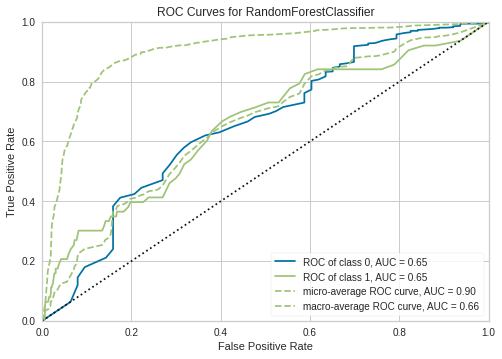

In [37]:
plot_model(rf, plot = 'auc')

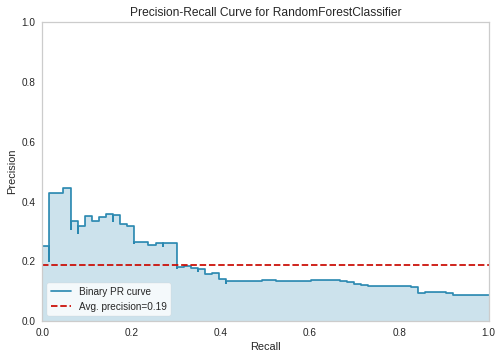

In [38]:
plot_model(rf, plot = 'pr')

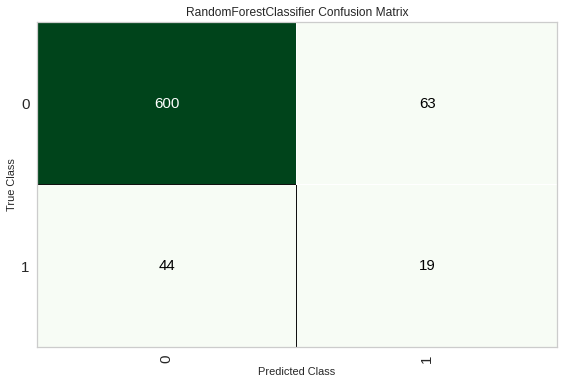

In [39]:
plot_model(rf, plot = 'confusion_matrix')

In [40]:
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


# RF - tuned parameter by AUC

In [41]:
tuned_rf_auc = tune_model(rf, optimize = 'AUC')
tuned_rf_auc_df = pull()
tuned_rf_auc_df_name = "tuned_rf_auc_df_"+ss+".csv"
tuned_rf_auc_df.to_csv(tuned_rf_auc_df_name)
tuned_rf_auc_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_df_name $tuned_rf_auc_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7370  0.6639  0.4375  0.1707  0.2456  0.1220  0.1419
1       0.6881  0.5738  0.3438  0.1196  0.1774  0.0377  0.0457
2       0.7152  0.6705  0.4762  0.1639  0.2439  0.1172  0.1426
3       0.6922  0.5873  0.3810  0.1290  0.1928  0.0568  0.0696
4       0.7274  0.7268  0.5873  0.1958  0.2937  0.1741  0.2146
5       0.7305  0.6958  0.5625  0.1957  0.2903  0.1695  0.2057
6       0.7289  0.6900  0.5625  0.1946  0.2892  0.1680  0.2042
7       0.7014  0.6708  0.5625  0.1773  0.2697  0.1418  0.1792
8       0.7152  0.6784  0.5156  0.1755  0.2619  0.1355  0.1658
9       0.7182  0.6893  0.4688  0.1667  0.2459  0.1184  0.1424
Mean    0.7154  0.6646  0.4898  0.1689  0.2510  0.1241  0.1512
SD      0.0158  0.0454  0.0791  0.0250  0.0377  0.0436  0.0537

Copying file://tuned_rf_auc_df_TOX21_ARE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  647.0 B/  647.0 B]                                                
Operation completed over 1 objects/647.0 B.                                      


In [42]:
predict_model(tuned_rf_auc)
tuned_rf_auc_p_df = pull()
tuned_rf_auc_p_df_name = "tuned_rf_auc_p_df_"+ss+".csv"
tuned_rf_auc_p_df.to_csv(tuned_rf_auc_p_df_name)
tuned_rf_auc_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_auc_p_df_name $tuned_rf_auc_p_df_path

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.6928  0.6248  ...  0.2064  0.0829  0.1076

[1 rows x 8 columns]

Copying file://tuned_rf_auc_p_df_TOX21_ARE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  121.0 B/  121.0 B]                                                
Operation completed over 1 objects/121.0 B.                                      


# RF -tuned parameter by F1

In [43]:
tuned_rf_f1 = tune_model(rf, optimize = 'F1')
tuned_rf_f1_df = pull()
tuned_rf_f1_df_name = "tuned_rf_f1_df_"+ss+".csv"
tuned_rf_f1_df.to_csv(tuned_rf_f1_df_name)
tuned_rf_f1_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_df_name $tuned_rf_f1_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7370  0.6639  0.4375  0.1707  0.2456  0.1220  0.1419
1       0.6881  0.5738  0.3438  0.1196  0.1774  0.0377  0.0457
2       0.7152  0.6705  0.4762  0.1639  0.2439  0.1172  0.1426
3       0.6922  0.5873  0.3810  0.1290  0.1928  0.0568  0.0696
4       0.7274  0.7268  0.5873  0.1958  0.2937  0.1741  0.2146
5       0.7305  0.6958  0.5625  0.1957  0.2903  0.1695  0.2057
6       0.7289  0.6900  0.5625  0.1946  0.2892  0.1680  0.2042
7       0.7014  0.6708  0.5625  0.1773  0.2697  0.1418  0.1792
8       0.7152  0.6784  0.5156  0.1755  0.2619  0.1355  0.1658
9       0.7182  0.6893  0.4688  0.1667  0.2459  0.1184  0.1424
Mean    0.7154  0.6646  0.4898  0.1689  0.2510  0.1241  0.1512
SD      0.0158  0.0454  0.0791  0.0250  0.0377  0.0436  0.0537

Copying file://tuned_rf_f1_df_TOX21_ARE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  647.0 B/  647.0 B]                                                
Operation completed over 1 objects/647.0 B.                                      


In [44]:
predict_model(tuned_rf_f1)
tuned_rf_f1_p_df = pull()
tuned_rf_f1_p_df_name = "tuned_rf_f1_p_df_"+ss+".csv"
tuned_rf_f1_p_df.to_csv(tuned_rf_f1_p_df_name)
tuned_rf_f1_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_f1_p_df_name $tuned_rf_f1_p_df_path

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.6928  0.6248  ...  0.2064  0.0829  0.1076

[1 rows x 8 columns]

Copying file://tuned_rf_f1_p_df_TOX21_ARE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  121.0 B/  121.0 B]                                                
Operation completed over 1 objects/121.0 B.                                      


# RF -tuned parameter by Kappa

In [45]:
tuned_rf_kappa = tune_model(rf, optimize = 'Kappa')
tuned_rf_kappa_df = pull()
tuned_rf_kappa_df_name = "tuned_rf_kappa_df_"+ss+".csv"
tuned_rf_kappa_df.to_csv(tuned_rf_kappa_df_name)
tuned_rf_kappa_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_df_name $tuned_rf_kappa_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7370  0.6639  0.4375  0.1707  0.2456  0.1220  0.1419
1       0.6881  0.5738  0.3438  0.1196  0.1774  0.0377  0.0457
2       0.7152  0.6705  0.4762  0.1639  0.2439  0.1172  0.1426
3       0.6922  0.5873  0.3810  0.1290  0.1928  0.0568  0.0696
4       0.7274  0.7268  0.5873  0.1958  0.2937  0.1741  0.2146
5       0.7305  0.6958  0.5625  0.1957  0.2903  0.1695  0.2057
6       0.7289  0.6900  0.5625  0.1946  0.2892  0.1680  0.2042
7       0.7014  0.6708  0.5625  0.1773  0.2697  0.1418  0.1792
8       0.7152  0.6784  0.5156  0.1755  0.2619  0.1355  0.1658
9       0.7182  0.6893  0.4688  0.1667  0.2459  0.1184  0.1424
Mean    0.7154  0.6646  0.4898  0.1689  0.2510  0.1241  0.1512
SD      0.0158  0.0454  0.0791  0.0250  0.0377  0.0436  0.0537

Copying file://tuned_rf_kappa_df_TOX21_ARE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  647.0 B/  647.0 B]                                                
Operation completed over 1 objects/647.0 B.                                      


In [46]:
predict_model(tuned_rf_kappa)
tuned_rf_kappa_p_df = pull()
tuned_rf_kappa_p_df_name = "tuned_rf_kappa_p_df_"+ss+".csv"
tuned_rf_kappa_p_df.to_csv(tuned_rf_kappa_p_df_name)
tuned_rf_kappa_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_kappa_p_df_name $tuned_rf_kappa_p_df_path

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.6928  0.6248  ...  0.2064  0.0829  0.1076

[1 rows x 8 columns]

Copying file://tuned_rf_kappa_p_df_TOX21_ARE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  121.0 B/  121.0 B]                                                
Operation completed over 1 objects/121.0 B.                                      


# RF -tuned parameter by MCC

In [47]:
tuned_rf_MCC = tune_model(rf, optimize = 'MCC')
tuned_rf_MCC_df = pull()
tuned_rf_MCC_df_name = "tuned_rf_MCC_df_"+ss+".csv"
tuned_rf_MCC_df.to_csv(tuned_rf_MCC_df_name)
tuned_rf_MCC_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_df_name $tuned_rf_MCC_df_path

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7370  0.6639  0.4375  0.1707  0.2456  0.1220  0.1419
1       0.6881  0.5738  0.3438  0.1196  0.1774  0.0377  0.0457
2       0.7152  0.6705  0.4762  0.1639  0.2439  0.1172  0.1426
3       0.6922  0.5873  0.3810  0.1290  0.1928  0.0568  0.0696
4       0.7274  0.7268  0.5873  0.1958  0.2937  0.1741  0.2146
5       0.7305  0.6958  0.5625  0.1957  0.2903  0.1695  0.2057
6       0.7289  0.6900  0.5625  0.1946  0.2892  0.1680  0.2042
7       0.7014  0.6708  0.5625  0.1773  0.2697  0.1418  0.1792
8       0.7152  0.6784  0.5156  0.1755  0.2619  0.1355  0.1658
9       0.7182  0.6893  0.4688  0.1667  0.2459  0.1184  0.1424
Mean    0.7154  0.6646  0.4898  0.1689  0.2510  0.1241  0.1512
SD      0.0158  0.0454  0.0791  0.0250  0.0377  0.0436  0.0537

Copying file://tuned_rf_MCC_df_TOX21_ARE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  647.0 B/  647.0 B]                                                
Operation completed over 1 objects/647.0 B.                                      


In [48]:
predict_model(tuned_rf_MCC)
tuned_rf_MCC_p_df = pull()
tuned_rf_MCC_p_df_name = "tuned_rf_MCC_p_df_"+ss+".csv"
tuned_rf_MCC_p_df.to_csv(tuned_rf_MCC_p_df_name)
tuned_rf_MCC_p_df_path = save_path_m+ss+"/"
!gsutil cp $tuned_rf_MCC_p_df_name $tuned_rf_MCC_p_df_path

Model  Accuracy     AUC  ...      F1   Kappa     MCC
0  Random Forest Classifier    0.6928  0.6248  ...  0.2064  0.0829  0.1076

[1 rows x 8 columns]

Copying file://tuned_rf_MCC_p_df_TOX21_ARE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  121.0 B/  121.0 B]                                                
Operation completed over 1 objects/121.0 B.                                      


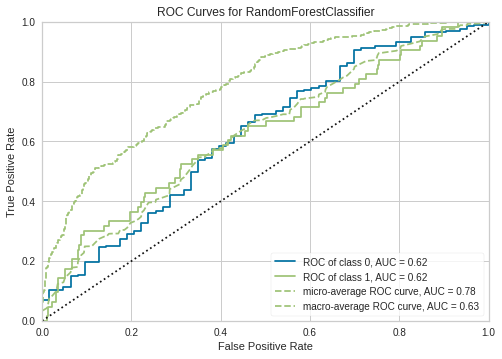

In [49]:
plot_model(tuned_rf_auc, plot = 'auc')

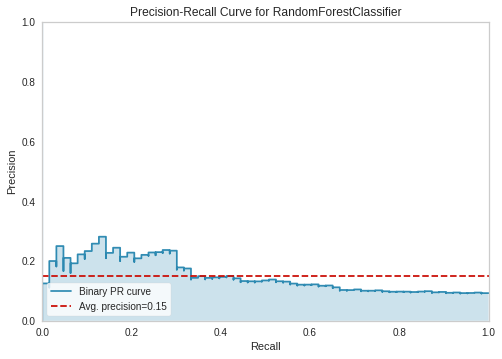

In [50]:
plot_model(tuned_rf_auc, plot = 'pr')

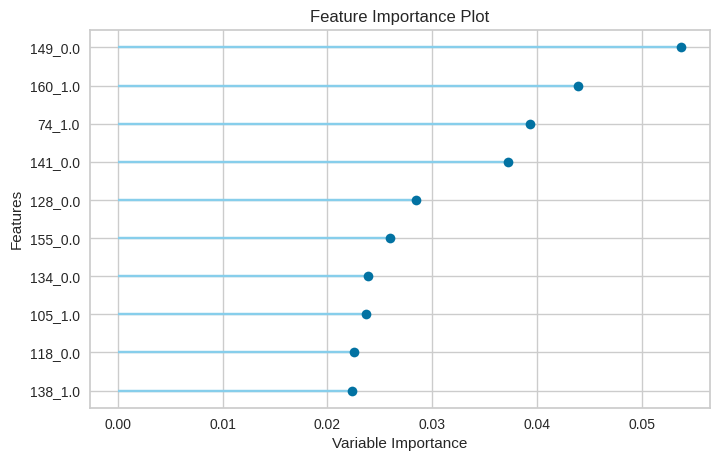

In [51]:
plot_model(tuned_rf_auc, plot='feature')

In [52]:
print(tuned_rf_auc)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


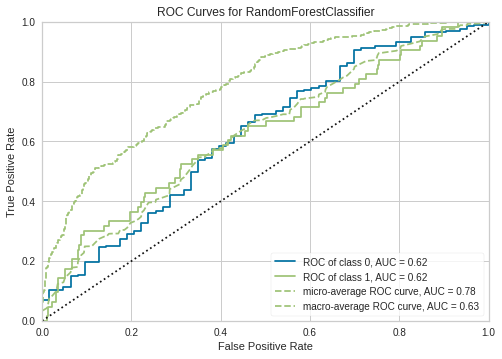

In [53]:
plot_model(tuned_rf_f1, plot = 'auc')

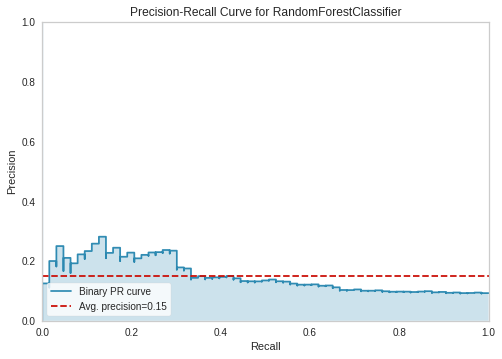

In [54]:
plot_model(tuned_rf_f1, plot = 'pr')

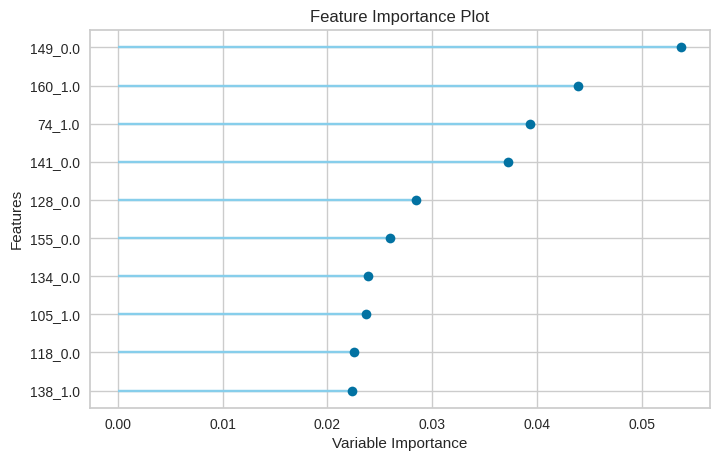

In [55]:
plot_model(tuned_rf_f1, plot='feature')

In [56]:
print(tuned_rf_f1)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


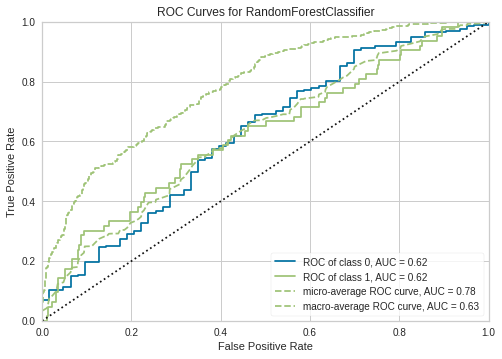

In [57]:
plot_model(tuned_rf_kappa, plot = 'auc')

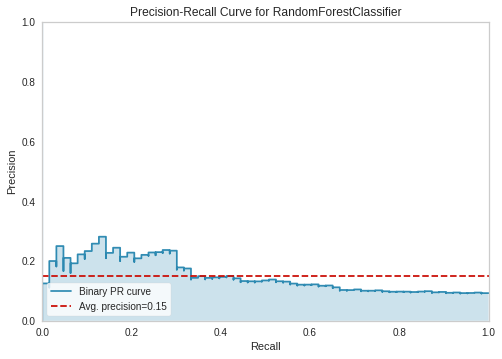

In [58]:
plot_model(tuned_rf_kappa, plot = 'pr')

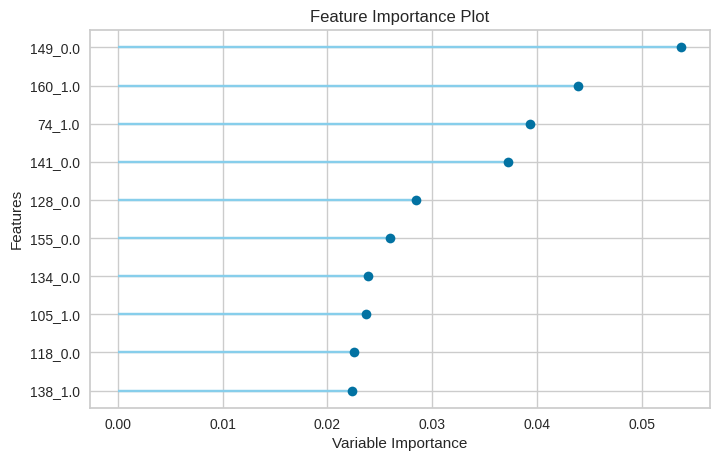

In [59]:
plot_model(tuned_rf_kappa, plot='feature')

In [60]:
print(tuned_rf_kappa)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


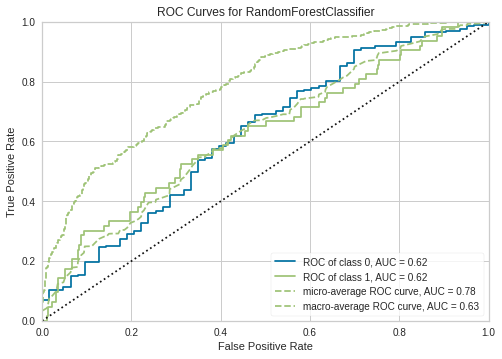

In [61]:
plot_model(tuned_rf_MCC, plot = 'auc')

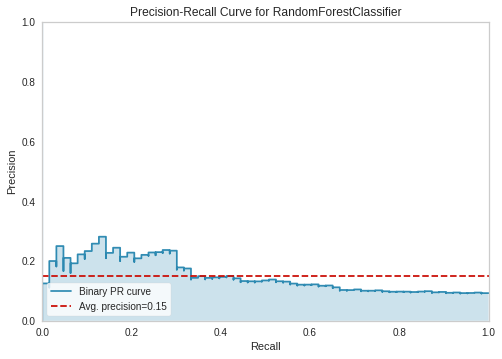

In [62]:
plot_model(tuned_rf_MCC, plot = 'pr')

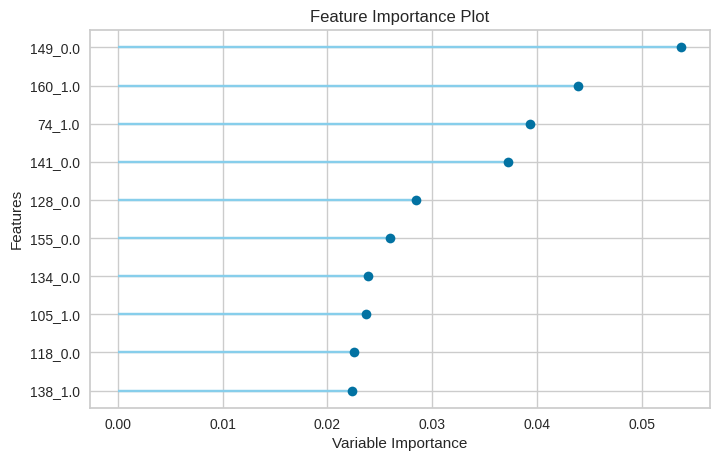

In [63]:
plot_model(tuned_rf_MCC, plot='feature')

In [64]:
print(tuned_rf_MCC)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)


# all algorithm compare with validation auc

In [65]:
best_specific = compare_models (sort = 'AUC', n_select = 6)
allml_df = pull()
allml_df_name = "allml_df_"+ss+".csv"
allml_df.to_csv(allml_df_name)
allml_df_path = save_path+"allml/"+ss+"/"
!gsutil cp $allml_df_name $allml_df_path

Model  Accuracy     AUC  Recall   Prec.  \
rf               Random Forest Classifier    0.8432  0.7064  0.3279  0.2602   
lightgbm  Light Gradient Boosting Machine    0.8460  0.7034  0.3154  0.2615   
et                 Extra Trees Classifier    0.8167  0.7016  0.3782  0.2307   
gbc          Gradient Boosting Classifier    0.8212  0.6791  0.3297  0.2199   
lr                    Logistic Regression    0.5453  0.6647  0.6956  0.1375   
lda          Linear Discriminant Analysis    0.5361  0.6632  0.7035  0.1362   
knn                K Neighbors Classifier    0.5923  0.6620  0.6798  0.1498   
ada                  Ada Boost Classifier    0.7209  0.6477  0.4648  0.1662   
nb                            Naive Bayes    0.4497  0.6021  0.6907  0.1163   
dt               Decision Tree Classifier    0.7555  0.5950  0.3956  0.1718   
qda       Quadratic Discriminant Analysis    0.1090  0.5029  0.9922  0.0980   
svm                   SVM - Linear Kernel    0.5687  0.0000  0.6611  0.1442   
ridge                    Ridge Classifier    0.5337  0.0000  0.7067  0.1359   

              F1   Kappa     MCC  TT (Sec)  
rf        0.2894  0.2029  0.2049    42.597  
lightgbm  0.2849  0.1998  0.2013    41.913  
et        0.2863  0.1882  0.1960    42.541  
gbc       0.2628  0.1659  0.1708    45.017  
lr        0.2296  0.0798  0.1333    42.537  
lda       0.2282  0.0774  0.1315    40.130  
knn       0.2455  0.1019  0.1569    44.049  
ada       0.2448  0.1182  0.1420    40.971  
nb        0.1979  0.0379  0.0706    40.751  
dt        0.2394  0.1199  0.1350    40.418  
qda       0.1784  0.0011  0.0167    40.059  
svm       0.2332  0.0884  0.1373    40.923  
ridge     0.2279  0.0770  0.1315    40.294

Copying file://allml_df_TOX21_ARE_BLA_agonist_ratio.csv [Content-Type=text/csv]...
/ [1 files][  1.1 KiB/  1.1 KiB]                                                
Operation completed over 1 objects/1.1 KiB.                                      
